In [34]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join

data_path = "/Users/deshenghu/Dropbox/Dataset_CS6220/ml-100k/u.data"

def read_file(path):
    res = ''
    if isfile(path):
        with open(path, 'rb') as f:
            res = f.read()
    return res

data = read_file(data_path)

from io import StringIO

s=str(data,'utf-8')

data = StringIO(s) 
column_name = ['user_id', 'movie_id', 'rating', 'timestamp']

df_data =pd.read_csv(data, sep='\t',names=column_name)

In [35]:
df_data


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [36]:
from sklearn.metrics import mean_squared_error as mse
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

In [37]:
userNums = df_data.user_id.unique().shape[0] ## userNums= 943
movieNums = df_data.movie_id.unique().shape[0] ## movieNums = 1682
user_movie_matrix = np.zeros((userNums, movieNums))

for idx,df_data in df_data.iterrows():
    user_movie_matrix[(df_data.user_id-1), (df_data.movie_id-1)] = df_data.rating



In [38]:
len(user_movie_matrix[0])

1682

In [39]:
def sim_users(u):
    """ This function is to genearte the similarity matrix of users
    Args
        u: user_movie_matrix
    Return
        similarity_matrix: the users' similarity matrix
    """  
    
    eps=1.0e-9
    
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    similarity_matrix = (step1 / step2 / step2.T)
    
    return similarity_matrix
    

def top_k(arr, self_idx, k):
    """ This function is to generate top k users_similarity_matrix's index and value
    Args
        arr: similarity matrix of users
        self_idx: the user's id
        k: the number of K nearest neighbours
               
    Return
        k_nn: {index of the element of users' simi_matrix : element of users' simi_matrix }, 
    """
    k_nn = {}
    rank = np.argsort(-1*arr)
    # Find the indices of array elements that are non-zero, grouped by element.ie. indices for element where rank == self_idx
    mt_idx = np.argwhere(rank == self_idx)
    # Return a new array with sub-arrays along an axis deleted. 
    rank = np.delete(rank,mt_idx)
    
    for i in rank[:k]:
        k_nn[i] = arr[i]

    return k_nn


def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    """ This function is to generate top k users_similarity_matrix's index and value
    Args
        m_utility: user_movie_matrix
        m_sim_users: similarity matrix of users
        user_idx: the user's id
        item_idx: item(i.e., movie)'s ID
        k: the number of K nearest neighbours
               
    Return
        rec_score: 
    """
    k_weight = top_k(arr=m_sim_users[:,user_idx],self_idx=user_idx,k=k)
    nn = []
    weight = []
    for key,value in k_weight.items():
        nn.append(key)
        weight.append(value)
    weight = np.array(weight)
    scores = m_utility[nn][:,item_idx]
    weight = weight[np.nonzero(scores)]#get rid of the user who didnt rate
    scores = scores[np.nonzero(scores)]
    if len(weight) == 1: 
        return scores[0]
    else:
        if np.sum(weight) != 0: # to avoid the case when divide by 0
            rec_score = (scores.T@weight)/np.sum(weight)
            return rec_score
        else:
            return 0
        
        
def recs_via_users(m_utility, m_sim_users, k, test_n):
    # randomly pick "test_n" users from the dataset
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                #ground truth
                true.append(m_utility[user_idx][item_idx])
                # Return number rounded to ndigits precision after the decimal point.
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                #prediction
                if p != 0:  #if we can predict.
                    pred.append(p) 
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))

In [40]:
similarity_users = sim_users(user_movie_matrix)
rec_via_users(user_movie_matrix,similarity_users,user_idx=0,item_idx=1,k=10)

3.2207465195150866

In [41]:
similarity_users

array([[ 1.        ,  0.16693098,  0.04745954, ...,  0.14861694,
         0.17950788,  0.39817474],
       [ 0.16693098,  1.        ,  0.11059132, ...,  0.16148478,
         0.17226781,  0.10579788],
       [ 0.04745954,  0.11059132,  1.        , ...,  0.10124256,
         0.13341615,  0.02655587],
       ..., 
       [ 0.14861694,  0.16148478,  0.10124256, ...,  1.        ,
         0.1016418 ,  0.09511958],
       [ 0.17950788,  0.17226781,  0.13341615, ...,  0.1016418 ,
         1.        ,  0.18246466],
       [ 0.39817474,  0.10579788,  0.02655587, ...,  0.09511958,
         0.18246466,  1.        ]])

In [42]:
import random
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(user_movie_matrix, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

1/50 5.84036202319
2/50 3.90639904457
3/50 3.04326415653
4/50 2.75808878766
5/50 2.27453049101
6/50 2.13567014232
7/50 1.94566030628
8/50 1.95282258016
9/50 1.91077125126
10/50 1.73673359597
11/50 1.56526276528
12/50 1.59285253281
13/50 1.65350281364
14/50 1.60606667311
15/50 1.51165244052
16/50 1.55918758698
17/50 1.55579945542
18/50 1.38757987203
19/50 1.30583980225
20/50 1.409218764
21/50 1.39470088049
22/50 1.3904410471
23/50 1.2503390006
24/50 1.36140350862
25/50 1.18564837288
26/50 1.30810390103
27/50 1.29872191118
28/50 1.2596364327
29/50 1.12568259377
30/50 1.21299516487
31/50 1.29414779995
32/50 1.24870416578
33/50 1.3642508448
34/50 1.36887724234
35/50 1.2741205512
36/50 1.33589721908
37/50 1.21618634694
38/50 1.22905027926
39/50 1.24831287087
40/50 1.30095877268
41/50 1.22313644814
42/50 1.17288101052
43/50 1.23212435227
44/50 1.21390326604
45/50 1.17287460897
46/50 1.09844468002
47/50 1.17563377708
48/50 1.14900484126
49/50 1.1687375745
50/50 1.24459889457


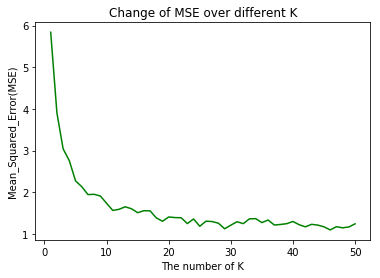

In [43]:
plt.plot(ks, mses, color='g')
plt.xlabel('The number of K')
plt.title('Change of MSE over different K')
plt.ylabel('Mean_Squared_Error(MSE)')
plt.show()

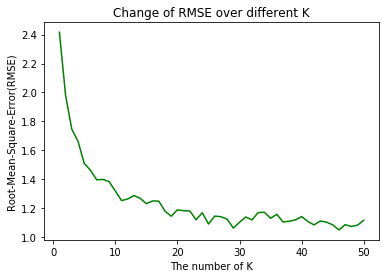

In [44]:
RMSEs = np.sqrt(mses)
plt.plot(ks, RMSEs, color='g')
plt.title('Change of RMSE over different K')
plt.xlabel('The number of K')
plt.ylabel('Root-Mean-Square-Error(RMSE)')
plt.show()

In [78]:

from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
import networkx 

import igraph

from numpy import genfromtxt

In [79]:
def krodetla(x,y):
    if x == y: 
        return 1
    else:
        return 0

def adjancymatrix(edges):
    points = []
    for (x,y) in edges:
        points.append(x)
        points.append(y)
    points = set(points)
    A = np.zeros((len(points),len(points)))
    for edge in edges:
        startId = edge[0]
        endId = edge[1]
        startIdx = pointId2Index(startId)
        endIdx = pointId2Index(endId)
        A[startIdx][endIdx] = 1
        A[endIdx][startIdx] = 1
    return A

def modularity(edges):
    m = len(edges)
    A = adjancymatrix(edges)
    edges = np.array(edges) - 1
    if m == 0 : return 0
    
    
    
    return Q

In [80]:
edges = [
    (1,2),
    (1,3),
    (1,4),
    (1,5),
    (1,6),
    (1,11),
    (2,3),
    (2,4),
    (2,5),
    (3,4),
    (3,5),
    (4,5),
    (6,11),
    (6,7),
    (6,8),
    (6,9),
    (6,10),
    (7,8),
    (7,9),
    (7,10),
    (8,9),
    (8,10),
    (9,10),
    (11,12),
    (11,13),
    (11,15),
    (11,14),
    (12,13),
    (12,14),
    (12,15),
    (13,14),
    (13,15),
    (14,15)
]

membership = [0]*5 + [1] * 5 + [2] * 5

In [81]:
membership

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

In [82]:
points = []
for (s,t) in edges:
    points.append(s)
    points.append(s)

In [83]:
import networkx 
G = networkx.from_edgelist(edges, create_using= networkx.Graph())


In [84]:
networkx.draw(G,with_labels=True, alpha=0.8, node_color='red',)

In [86]:
points = []
for x,y in edges:
    points.append(x)
    points.append(y)
points = set(points)

g = igraph.Graph()
g.add_vertices(len(points))
g.add_edges(np.array(edges)-1)

In [87]:
edges = []
for e in g.es:
    edges.append(e.tuple)
G = networkx.from_edgelist(edges, create_using= networkx.Graph())
networkx.draw(G,with_labels=True, alpha=0.8, node_color='red',)
g.edge_betweenness()

[11.0,
 11.0,
 11.0,
 11.0,
 25.0,
 25.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 25.0,
 11.0,
 11.0,
 11.0,
 11.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 11.0,
 11.0,
 11.0,
 11.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [88]:
a = np.array(g.edge_betweenness())
g.delete_edges(np.argwhere(a == np.amax(a)).flatten())
edges = []
for e in g.es:
    edges.append(e.tuple)
G = networkx.from_edgelist(edges, create_using= networkx.Graph())
networkx.draw(G,with_labels=True, alpha=0.8, node_color='red',)
g.edge_betweenness()


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [89]:

np.array([2,3]).T @ np.array([2,3])

13

In [92]:
vertexs = genfromtxt('/Users/deshenghu/Dropbox/Dataset_CS6220/edges_sampled_map_2K.csv',delimiter=',').tolist()
membership = genfromtxt('/Users/deshenghu/Dropbox/Dataset_CS6220/community_membership_2K.csv',delimiter=',').tolist()

points = []
edges = []
for y in vertexs:
    points.append(int(y[0]))
    points.append(int(y[1]))
    edges.append((int(y[0]),int(y[1])))
points = set(points)

member = []
for m in membership:
    member.append(int(m[1]))

In [93]:
len(edges)

2098

In [94]:
g = igraph.Graph()
g.add_vertices(len(points))
g.add_edges(edges)

In [95]:
g.modularity(member)

0.4109674564090726

In [96]:
mod = []
i = 0
edgesnumber = 2300
while i < 1000 and edgesnumber > 100:
    edgesnumber = g.ecount()
    a = np.array(g.edge_betweenness())
    g.delete_edges(np.argwhere(a == np.amax(a)).flatten())
    mod.append((g.modularity(membership=member),g.ecount()))
    i += 1

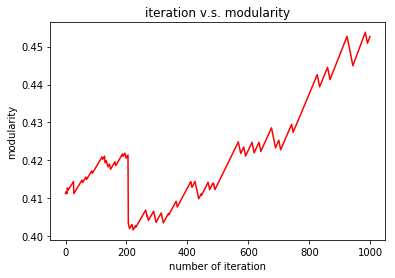

In [101]:
plt.plot(np.asarray(mod)[:,0],color='r')
plt.title('iteration v.s. modularity')
plt.xlabel('number of iteration')
plt.ylabel('modularity')
plt.show()

In [28]:
import networkx as nx
import math
import csv
import random as rand
import sys

edges = []
G = nx.Graph()
#with open('/Users/deshenghu/Dropbox/Dataset_CS6220/edges_sampled_3K.csv') as f:
with open('/Users/deshenghu/Dropbox/Dataset_CS6220/edges_sampled_map_2K.csv') as f:
    for row in csv.reader(f.read().splitlines()):
        u, v = [i for i in row]
        G.add_edge(int(u),int(v),weight=1.0)
        edges.append([u,v])
n = G.number_of_nodes()
A = nx.adj_matrix(G)
m = 0
# m is to aggregate the adjacency matrix
for i in range(0,n):
    for j in range(0,n):
        m += A[i,j]
m = m/2.0
numCommunity = [0]
#modurality = []
iteration = [0]
modurality = [0]


def between(g,a,b):
    bt = 0
    for i in range(n):
        for j in range(n):
            if (i != j):
                paths = g.shortest_paths(i,j)
                nn = len(paths)
                num = 0
                if nn > 0:
                    for path in paths:
                        if a in path and b in path:
                            num += 1
                    bt += num/nn
    return(bt)



def edgebt(g):
    bt = []
    for edge in edges:
        bt.append(between(g,int(edge[0]),int(edge[1])))

In [29]:
# this is to remove the edge corresponding to the max betweeness value and thus geneatte new division of the network (i.e., new communities)
def community(G):
    init = nx.number_connected_components(G)
    ncomp = init
    while ncomp <= init:
        bw = nx.edge_betweenness_centrality(G, weight='weight')
        max_ = max(bw.values())
        for k in bw.keys():
            v = bw[k]
            if float(v) == max_:
                G.remove_edge(k[0],k[1])
        ncomp = nx.number_connected_components(G)
        
# this is to update the degree dictionary after the communited is updated(i.e., splited)        
def update(A, nodes):
    deg_dict = {}
    n = len(nodes) 
    B = A.sum(axis = 1)
    for i in range(n):
        deg_dict[nodes[i]] = B[i, 0]
    return deg_dict


# this is to calculate the modularity score given a particular division of a network into certain number of communities
def modul(G, deg_, m_):
    new = nx.adj_matrix(G)
    new_deg = {}
    new_deg = update(new, list(G.nodes()))
    comps = nx.connected_components(G)
    print('# of communities in decomposed G: %d' % nx.number_connected_components(G))
    numCommunity.append(nx.number_connected_components(G))
    mod = 0
    for c in comps:
        ewc = 0
        re = 0
        for u in c:
            ewc += new_deg[u]
            re += deg_[u]
        # here float(ewc) is aggregating the A(ij) while float(re*re) is K(i)K(j)   
        mod += (float(ewc) - float(re*re)/float(2*m_) )
    ## m_ is the number of edges;    
    mod = mod/float(2*m_)
    return mod

In [30]:
## this is the implementation of the runGirvanNewman algorithms
def runGirvanNewman(G, Orig_deg, m_):
    #let's find the best split of the graph
    BestQ = 0.0
    i = 0
    Q = 0.0
    while True: 
        i +=1
        iteration.append(i)
        community(G)
        Q = modul(G, Orig_deg, m_);
        print ("Modularity of decomposed G: %f" % Q)
        modurality.append(Q)
        if Q > BestQ:
            BestQ = Q
            Bestcomps = nx.connected_components(G)    #Best Split
            print ("Components:", Bestcomps)
        if G.number_of_edges() == 0:
            break
    if BestQ > 0.0:
        print("Max modularity (Q): %f" % BestQ)
        print("Graph communities:", Bestcomps)
    else:
        print("Max modularity (Q): %f" % BestQ)

In [31]:
Orig_deg = {}
Orig_deg = update(A, list(G.nodes()))

runGirvanNewman(G, Orig_deg, m)

# of communities in decomposed G: 6
Modularity of decomposed G: 0.410967
Components: <generator object connected_components at 0x11aea2fc0>
# of communities in decomposed G: 7
Modularity of decomposed G: 0.412436
Components: <generator object connected_components at 0x11b080eb8>
# of communities in decomposed G: 8
Modularity of decomposed G: 0.413676
Components: <generator object connected_components at 0x11ae8e0f8>
# of communities in decomposed G: 9
Modularity of decomposed G: 0.414164
Components: <generator object connected_components at 0x11b080888>
# of communities in decomposed G: 10
Modularity of decomposed G: 0.414717
Components: <generator object connected_components at 0x116a66f10>
# of communities in decomposed G: 21
Modularity of decomposed G: 0.413240
# of communities in decomposed G: 22
Modularity of decomposed G: 0.412767
# of communities in decomposed G: 23
Modularity of decomposed G: 0.413044
# of communities in decomposed G: 24
Modularity of decomposed G: 0.412772
# o

# of communities in decomposed G: 159
Modularity of decomposed G: 0.295366
# of communities in decomposed G: 160
Modularity of decomposed G: 0.293763
# of communities in decomposed G: 161
Modularity of decomposed G: 0.292618
# of communities in decomposed G: 162
Modularity of decomposed G: 0.290130
# of communities in decomposed G: 163
Modularity of decomposed G: 0.287334
# of communities in decomposed G: 164
Modularity of decomposed G: 0.284153
# of communities in decomposed G: 165
Modularity of decomposed G: 0.281741
# of communities in decomposed G: 166
Modularity of decomposed G: 0.281693
# of communities in decomposed G: 167
Modularity of decomposed G: 0.280319
# of communities in decomposed G: 168
Modularity of decomposed G: 0.278087
# of communities in decomposed G: 169
Modularity of decomposed G: 0.276058
# of communities in decomposed G: 170
Modularity of decomposed G: 0.275587
# of communities in decomposed G: 171
Modularity of decomposed G: 0.274392
# of communities in decom

# of communities in decomposed G: 276
Modularity of decomposed G: 0.052233
# of communities in decomposed G: 277
Modularity of decomposed G: 0.049251
# of communities in decomposed G: 278
Modularity of decomposed G: 0.048086
# of communities in decomposed G: 279
Modularity of decomposed G: 0.044214
# of communities in decomposed G: 280
Modularity of decomposed G: 0.041333
# of communities in decomposed G: 281
Modularity of decomposed G: 0.038624
# of communities in decomposed G: 282
Modularity of decomposed G: 0.036167
# of communities in decomposed G: 283
Modularity of decomposed G: 0.034518
# of communities in decomposed G: 284
Modularity of decomposed G: 0.033323
# of communities in decomposed G: 285
Modularity of decomposed G: 0.031891
# of communities in decomposed G: 286
Modularity of decomposed G: 0.029662
# of communities in decomposed G: 287
Modularity of decomposed G: 0.027656
# of communities in decomposed G: 289
Modularity of decomposed G: 0.021591
# of communities in decom

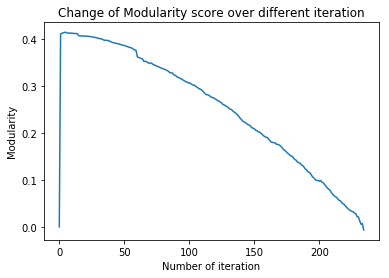

In [32]:
import matplotlib.pyplot as plt
#plt.plot(numCommunity,modurality)
plt.plot(iteration,modurality)
plt.title('Change of Modularity score over different iteration')
plt.xlabel("Number of iteration")
plt.ylabel("Modularity")
plt.show()

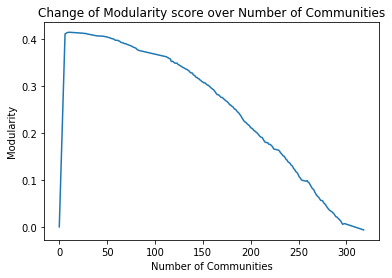

In [33]:
import matplotlib.pyplot as plt
plt.plot(numCommunity,modurality)
#plt.plot(iteration,modurality)
plt.title('Change of Modularity score over Number of Communities')
plt.xlabel("Number of Communities")
plt.ylabel("Modularity")
plt.show()

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
X, y = np.arange(10).reshape((5, 2)), np.array(list(range(5)))

In [31]:
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [32]:
y

array([0, 1, 2, 3, 4])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y)

/Users/deshenghu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [7]:
X_train

array([[4, 5],
       [0, 1],
       [6, 7]])

In [8]:
y_train

[2, 0, 3]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, list(y), train_size=0.4, random_state=42)

/Users/deshenghu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
X_train

array([[0, 1],
       [6, 7]])

In [18]:
y_train

[0, 3]

In [15]:
X_test

array([[2, 3],
       [8, 9],
       [4, 5],
       [0, 1]])

In [24]:
train_test_split(y, shuffle=True)

[[0, 3, 1], [2, 4]]

In [25]:
train_test_split(y, shuffle=False)

[[0, 1, 2], [3, 4]]

In [38]:
# code source from http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#
# code source from http://www.nltk.org/book/ch02.html
# code source from http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html

from sklearn.datasets import fetch_20newsgroups

import nltk
from nltk.corpus import stopwords
import string


# extracts the archive contents in the ~/scikit_learn_data/20news_home folder 
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

################# this part is for pre-processing the text file which isn't mandatory
# get rid of the stopwords and punctuation
nltk.download('stopwords')
stop_word =stopwords.words('english')
punctuation = string.punctuation
stopw_punctuation = list(stop_word) + list(punctuation)

# from nltk.tokenize import word_tokenize

# # to tokenize the word
# for j in range(len(newsgroups_train.data)):
#     newsgroups_train.data[j] = " ".join([w for w in word_tokenize(newsgroups_train.data[j]) if w not in stopw_punctuation])
#    # print(newsgroups_train.data[])
# for j in range(len(newsgroups_test.data)):
#     newsgroups_test.data[j] = " ".join([w for w in word_tokenize(newsgroups_train.data[j]) if w not in stopw_punctuation])

#print(len(newsgroups_train.data))
#print(newsgroups_train.data[1])

##############

# from http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, stop_words = 'english')
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
# the test data set don't need to fit
vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, stop_words = 'english', vocabulary = vectorizer.vocabulary_)
vectors_test = vectorizer.fit_transform(newsgroups_test.data)
print(vectors_train.shape)
print(vectors_test.shape)


news_train = vectors_train
news_test = vectors_test
print(type(newsgroups_train.data))
print(len(newsgroups_train.data))
print(len(newsgroups_train.data[0]))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deshenghu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(11314, 129791)
(7532, 129791)
<class 'list'>
11314
721


In [53]:
print(len(newsgroups_train.data))

11314


In [51]:

from sklearn.model_selection import train_test_split



X_train, X_test, Y_train, Y_test = train_test_split(newsgroups_train.data, newsgroups_train.target, train_size =0.2, stratify = newsgroups_train.target )

/Users/deshenghu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
X_train[0]

"From: agallagh@slate.mines.colorado.edu (GALLAGHER ANDREA J )\nSubject: Re: Forcing a window manager to accept specific coordinates for a window\nOrganization: Colorado School of Mines\nLines: 18\n\n\nIn article <C5r25y.HFz@cs.columbia.edu> Ethan Solomita writes:\n> \n> \tHi. I'm trying to figure out how to make a window manager\n> place the window where the create window command tells it,\n> regardless of what it may think is right. (my application has\n> reason to know better)\n> \n> \tI don't want to set the override-redirect because I do\n> want all the embellishments that the window manager gives, I just\n> want the wm to accept my choice of location.\n\n\twindow = XCreateWindow(...);\n\tXSetTransientForHint(display, window, window);\n\tXMapWindow(...);\n\nThis is probably cheating, and some window managers might STILL refuse to \ngive it a border and all that other stuff, but it usually works.\n"

In [59]:
Y_train[0:100]

array([ 5,  3, 15, 12, 13,  1, 18, 15,  2, 19, 10,  3, 17, 14,  5, 15, 19,
       15, 10,  1, 17, 14,  4, 10, 18, 10, 18,  9,  8,  1,  1, 17,  2,  2,
        5,  9,  2,  9, 11,  9,  6, 17,  0,  8, 16, 17, 18,  1, 17,  2,  2,
        2,  1, 11,  0,  4,  4, 14, 14,  4, 17,  6,  7,  5,  4, 10,  9, 13,
       13, 11,  2, 14,  2, 19,  1, 14, 10, 16,  8, 10,  0,  0, 13, 15, 18,
       13, 12, 19, 16,  4,  3,  9, 17, 11, 11,  9,  2, 10, 15, 18])